In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from tqdm import tqdm
import random

c:\Users\Anne-\anaconda3\envs\introML\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Den angitte prosedyren ble ikke funnet'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# PREPROCESSING

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch_generator1 = torch.Generator().manual_seed(42)
torch_generator2 = torch.Generator().manual_seed(43)

# 1. Load the Dataset (midlertidig, for split + mean/std)

temp_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

data_dir = '../data/vehicle-type-detection'  # Assuming you run the script from the parent directory
full_dataset_temp = datasets.ImageFolder(data_dir, transform=temp_transform)

# 2. Split the Data (brukes kun til å finne indekser)

train_size = int(0.8 * len(full_dataset_temp))
val_size = len(full_dataset_temp) - train_size
train_dataset_temp, val_dataset_temp = random_split(
    full_dataset_temp,
    [train_size, val_size],
    generator=torch_generator1
)

# 3. Calculate Mean and STD on train data

TEMP_BATCH_SIZE = 64
temp_train_loader = DataLoader(train_dataset_temp, batch_size=TEMP_BATCH_SIZE, shuffle=False)

def calculate_mean_and_std(loader):
    """Calculates channel-wise mean and standard deviation from a DataLoader."""
    channels_sum, channels_sq_sum, num_batches = 0, 0, 0

    # Iterate over the dataset and accumulate sums
    for data, _ in tqdm(loader, desc="Calculating Stats"):
        # data shape is (batch_size, channels, height, width)
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sq_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    # Final calculation
    mean = channels_sum / num_batches
    # E[(X - mu)^2] = E[X^2] - (E[X])^2
    std = torch.sqrt(channels_sq_sum / num_batches - mean**2)

    # Convert tensors to lists/tuples of floats for use in transforms.Normalize
    return mean.tolist(), std.tolist()

MEAN, STD = calculate_mean_and_std(temp_train_loader)

# 4. Define Preprocessing Pipelines

# --> TRAIN: med random augmentering
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),     # Crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# --> VAL/TEST: ingen random, kun deterministisk resize + normalize
eval_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# Lag to "full-datasets" med ulike transforms
full_dataset_train = datasets.ImageFolder(data_dir, transform=train_transform)
full_dataset_eval  = datasets.ImageFolder(data_dir, transform=eval_transform)

# Retain the original indices from the first random_split
train_indices = train_dataset_temp.indices
val_indices   = val_dataset_temp.indices

# Create the final, fully transformed train and validation/test datasets
train_dataset   = Subset(full_dataset_train, train_indices)
val_test_dataset = Subset(full_dataset_eval,  val_indices)

# Split val_indices videre i val og test med samme generator som før
val_dataset, test_dataset = random_split(
    val_test_dataset,
    [val_size // 2, val_size - val_size // 2],
    generator=torch_generator2
)

# Check sizes to ensure split is preserved
print(f"Final Train Size: {len(train_dataset)}")
print(f"Final Validation Size: {len(val_dataset)}")
print(f"final test size: {len(test_dataset)}")

# 5. Create DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

print(type(train_dataset))


Calculating Stats: 100%|██████████| 17/17 [00:10<00:00,  1.55it/s]

Final Train Size: 1048
Final Validation Size: 131
final test size: 131
<class 'torch.utils.data.dataset.Subset'>


In [12]:
class CNN_1(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.features = nn.Sequential(
             # in_channel = 1 since we use grey scale, out_channel corresponds to # feature maps, kernel_
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            #nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # calculate dimensionality of flatten_dim
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 224, 224)
            out = self.features(dummy)
            flatten_dim = out.view(1, -1).shape[1]


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flatten_dim, out_features= 128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))
    
cnn = CNN_1()


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN_1().to(device)

num_epochs = 5
learning_rate = 0.001
#weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

In [14]:
train_loss_list = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')
    train_loss = 0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_list.append(train_loss / len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}")

Epoch 1/5: Training loss = 1.4844944549329353
Epoch 2/5: Training loss = 1.266832815878319
Epoch 3/5: Training loss = 1.1226217584176497
Epoch 4/5: Training loss = 1.1972181164857112
Epoch 5/5: Training loss = 1.0519796483444446


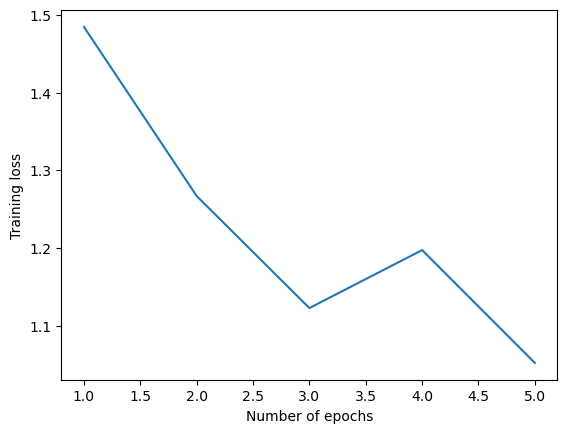

In [15]:
plt.plot(range(1, num_epochs + 1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.show()

In [16]:
model.eval()  # sett modellen i eval-modus
val_correct = 0
val_total = 0

with torch.no_grad():  # ingen gradienter under evaluering
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                 # shape: (batch_size, num_classes)
        _, y_pred = torch.max(outputs, dim=1)   # predikert klasse per sample

        val_total += labels.size(0)             # legg til antall bilder i batchen
        val_correct += (y_pred == labels).sum().item()

val_acc = 100 * val_correct / val_total
print(f"Val set accuracy = {val_acc:.2f} %")


Val set accuracy = 70.99 %


In [19]:
import torch.optim as optim
from torch.utils.data import DataLoader
import itertools
import copy

class CNN(nn.Module):
    def __init__(
        self,
        num_classes: int = 5,
        conv_kernel_size: int = 3,
        conv_stride: int = 1,
        padding: int = 1,
        pool_kernel_size: int = 2,
        input_size=(1, 224, 224),
    ):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=conv_kernel_size,
                stride=conv_stride,
                padding=padding,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size),

            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=conv_kernel_size,
                stride=conv_stride,
                padding=padding,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size),
        )

        # Finn flatten-dim automatisk
        with torch.no_grad():
            dummy = torch.zeros(1, *input_size)
            out = self.features(dummy)
            flatten_dim = out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [20]:
def train_one_model(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=5,
    lr=1e-3,
    weight_decay=1e-4,
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.to(device)

    best_val_acc = 0.0
    best_state = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        # ---- TRAIN ----
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # ---- VALIDATION ----
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, preds = torch.max(outputs, dim=1)

                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    # returner beste val-accuracy og state_dict
    return best_val_acc, best_state


In [22]:
num_classes = 5
# Hyperparametere å søke over
padding_values        = [0, 1]
conv_stride_values    = [1, 2]           # stride kan ikke være 0
conv_kernel_values    = [3, 5]
pool_kernel_values    = [2, 3]
learning_rates        = [1e-3, 3e-4]
batch_sizes           = [16, 32]

search_space = list(itertools.product(
    padding_values,
    conv_stride_values,
    conv_kernel_values,
    pool_kernel_values,
    learning_rates,
    batch_sizes
))

best_config = None
best_val_acc = 0.0
best_model_state = None

input_size = (1, 224, 224)  # siden du bruker 224x224 grayscale
num_epochs = 5               # du kan endre dette

for (
    padding,
    conv_stride,
    conv_kernel,
    pool_kernel,
    lr,
    batch_size
) in search_space:

    print(
        f"\n=== Testing config: "
        f"padding={padding}, conv_stride={conv_stride}, "
        f"conv_kernel={conv_kernel}, pool_kernel={pool_kernel}, "
        f"lr={lr}, batch_size={batch_size} ==="
    )

    # Ny dataloader for denne batch-size
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Bygg modell
    try:
        model = CNN(
            num_classes=num_classes,
            conv_kernel_size=conv_kernel,
            conv_stride=conv_stride,
            padding=padding,
            pool_kernel_size=pool_kernel,
            input_size=input_size,
        )
    except RuntimeError as e:
        print("Config crashed (sannsynligvis pga for liten feature map):", e)
        continue

    val_acc, state = train_one_model(
        model,
        train_loader,
        val_loader,
        device,
        num_epochs=num_epochs,
        lr=lr,
        weight_decay=1e-4,   # kan du også tune hvis du vil
    )

    print(f"Validation accuracy for this config: {val_acc:.2f} %")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = {
            "padding": padding,
            "conv_stride": conv_stride,
            "conv_kernel": conv_kernel,
            "pool_kernel": pool_kernel,
            "lr": lr,
            "batch_size": batch_size,
        }
        best_model_state = state

print("\n=== GRID SEARCH DONE ===")
print(f"Best val accuracy: {best_val_acc:.2f} %")
print("Best config:", best_config)

# Hvis du vil bruke beste modell videre:
best_model = CNN(
    num_classes=num_classes,
    conv_kernel_size=best_config["conv_kernel"],
    conv_stride=best_config["conv_stride"],
    padding=best_config["padding"],
    pool_kernel_size=best_config["pool_kernel"],
    input_size=input_size,
)
best_model.load_state_dict(best_model_state)
best_model.to(device)
best_model.eval()



=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=2, lr=0.001, batch_size=16 ===


c:\Users\Anne-\anaconda3\envs\introML\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation accuracy for this config: 61.07 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=2, lr=0.001, batch_size=32 ===
Validation accuracy for this config: 62.60 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=2, lr=0.0003, batch_size=16 ===
Validation accuracy for this config: 73.28 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=2, lr=0.0003, batch_size=32 ===
Validation accuracy for this config: 74.05 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=3, lr=0.001, batch_size=16 ===
Validation accuracy for this config: 72.52 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=3, lr=0.001, batch_size=32 ===
Validation accuracy for this config: 74.05 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=3, lr=0.0003, batch_size=16 ===
Validation accuracy for this config: 72.52 %

=== Testing config: padding=0, conv_stride=1, conv_

CNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5408, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [39]:
class FINAL_CNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.features = nn.Sequential(
             # in_channel = 1 since we use grey scale, out_channel corresponds to # feature maps, kernel_
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # calculate dimensionality of flatten_dim
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 224, 224)
            out = self.features(dummy)
            flatten_dim = out.view(1, -1).shape[1]


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flatten_dim, out_features= 128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=5),
        )

    def forward(self, x):
        return self.classifier(self.features(x))
    
final_cnn = FINAL_CNN()

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FINAL_CNN().to(device)

num_epochs = 90
learning_rate = 0.001
weight_decay = 1e-4
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Epoch 1/90: Train Loss = 1.3397, Train Acc = 0.4342 | Val Loss = 0.8718, Val Acc = 0.7023
Epoch 2/90: Train Loss = 1.1796, Train Acc = 0.5601 | Val Loss = 0.8426, Val Acc = 0.6794
Epoch 3/90: Train Loss = 1.0730, Train Acc = 0.5935 | Val Loss = 0.7349, Val Acc = 0.7405
Epoch 4/90: Train Loss = 1.0132, Train Acc = 0.6240 | Val Loss = 0.7022, Val Acc = 0.7710
Epoch 5/90: Train Loss = 0.9257, Train Acc = 0.6450 | Val Loss = 0.5647, Val Acc = 0.7863
Epoch 6/90: Train Loss = 0.8735, Train Acc = 0.6784 | Val Loss = 0.5337, Val Acc = 0.8244
Epoch 7/90: Train Loss = 0.8625, Train Acc = 0.6756 | Val Loss = 0.5301, Val Acc = 0.8168
Epoch 8/90: Train Loss = 0.7975, Train Acc = 0.6994 | Val Loss = 0.5644, Val Acc = 0.8015
Epoch 9/90: Train Loss = 0.7877, Train Acc = 0.7156 | Val Loss = 0.5967, Val Acc = 0.7863
Epoch 10/90: Train Loss = 0.7607, Train Acc = 0.7252 | Val Loss = 0.5032, Val Acc = 0.8168
Epoch 11/90: Train Loss = 0.7451, Train Acc = 0.7118 | Val Loss = 0.5721, Val Acc = 0.8550
Epoch 12

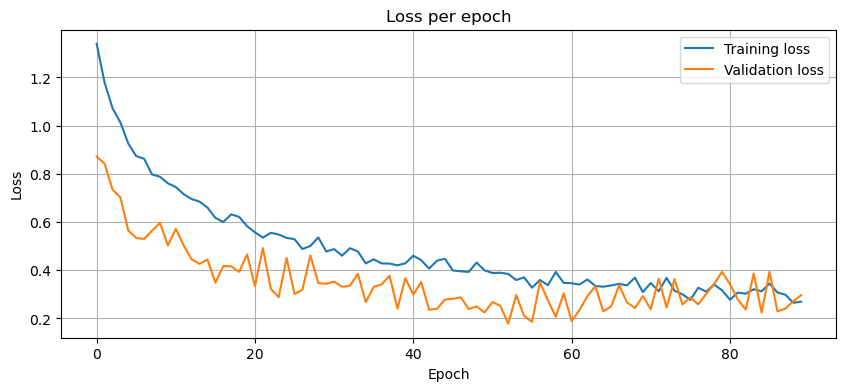

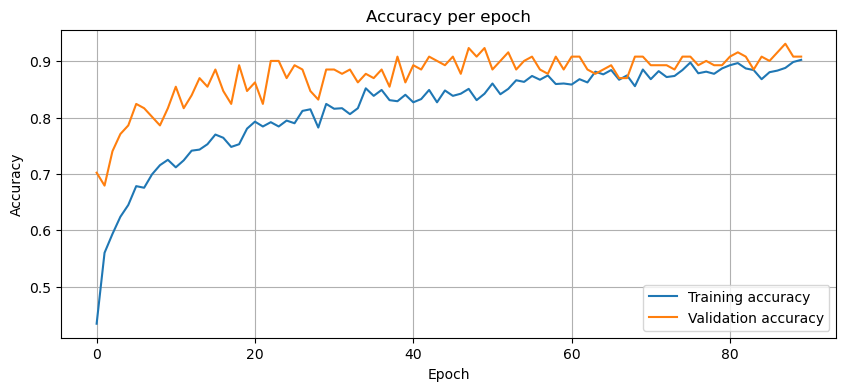

In [48]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')

    ### ---- TRAIN ---- ###
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / total
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    ### ---- VALIDATION ---- ###
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    print(f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_accuracy:.4f} | "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.4f}")

### ---- PLOTS ---- ###

# Loss curves
plt.figure(figsize=(10, 4))
plt.plot(train_loss_list, label="Training loss")
plt.plot(val_loss_list, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Loss per epoch")
plt.show()

# Accuracy curves
plt.figure(figsize=(10, 4))
plt.plot(train_acc_list, label="Training accuracy")
plt.plot(val_acc_list, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.title("Accuracy per epoch")
plt.show()


In [42]:
train_loss_list = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')
    train_loss = 0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_list.append(train_loss / len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}")

Epoch 1/50: Training loss = 1.4094309933257825
Epoch 2/50: Training loss = 1.1833044137015487
Epoch 3/50: Training loss = 1.0957734196475057
Epoch 4/50: Training loss = 1.0639930963516235
Epoch 5/50: Training loss = 0.9403964380423228
Epoch 6/50: Training loss = 0.9496158045349699
Epoch 7/50: Training loss = 0.8722881444475867
Epoch 8/50: Training loss = 0.8657613252148484
Epoch 9/50: Training loss = 0.8506264049898494
Epoch 10/50: Training loss = 0.7935233414173126
Epoch 11/50: Training loss = 0.7758483254548275
Epoch 12/50: Training loss = 0.7194340687358018
Epoch 13/50: Training loss = 0.6756304208979462
Epoch 14/50: Training loss = 0.691959691770149
Epoch 15/50: Training loss = 0.6957441062638254
Epoch 16/50: Training loss = 0.6744773442094977
Epoch 17/50: Training loss = 0.6046310888998436
Epoch 18/50: Training loss = 0.6546224387306155
Epoch 19/50: Training loss = 0.6008266174432003
Epoch 20/50: Training loss = 0.6202987102848111
Epoch 21/50: Training loss = 0.5944989264914484
Ep

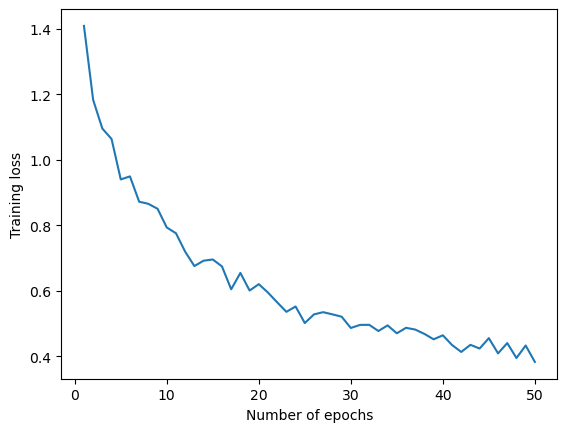

In [43]:
plt.plot(range(1, num_epochs + 1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.show()

In [44]:
model.eval()  # sett modellen i eval-modus
val_correct = 0
val_total = 0
all_true= []
all_preds = []

with torch.no_grad():  # ingen gradienter under evaluering
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                 # shape: (batch_size, num_classes)
        print('outputs: ', outputs)

        _, y_pred = torch.max(outputs, dim=1)   # predikert klasse per sample
        print('predication for this output: ', y_pred)

        all_true.extend(labels.numpy())
        all_preds.extend(y_pred)

        val_total += labels.size(0)             # legg til antall bilder i batchen
        val_correct += (y_pred == labels).sum().item()

val_acc = 100 * val_correct / val_total
print(f"Val set accuracy = {val_acc:.2f} %")


outputs:  tensor([[ -1.7850, -18.9903,  25.7236, -17.9272,  -0.5043],
        [  3.0831,  -9.1522,   0.2903,   3.3438,  -0.0413],
        [ -2.3843,   5.4973,   0.5864,  -1.2298,  -1.9487],
        [  2.5517, -12.1555,  -1.2410,   6.7799,   3.3014],
        [ -0.7683, -20.6359,  19.3652, -17.3347,  -0.4806],
        [ -4.9298, -16.4221,  15.8470, -12.0205,   3.2407],
        [ -2.0670,   8.6090,  -1.4253,   0.5888,  -1.0458],
        [ -3.5033,  12.5411,  -2.1872,   0.1739,  -0.4839],
        [  2.3391,  -8.3878,  -2.8009,   6.5019,  -0.4199],
        [ -0.8511, -17.7649,  21.4157, -19.0200,  -1.6100],
        [  1.3242, -11.5781,   1.3365,   2.2147,   1.6461],
        [ -0.9555, -12.0983,  -2.2777,   8.7496,   0.6422],
        [ -1.6072, -14.7982,  15.4106, -16.9648,   1.3297],
        [ -1.6310, -15.9874,   4.7356,   0.0469,   3.7545],
        [ -2.6935, -15.4184,  28.5283, -17.0878,  -1.7392],
        [  4.8381, -12.0279,  -3.0836,   0.6826,   3.4131]])
predication for this output: 

In [45]:
from torchinfo import summary

summary(model, input_size=(1, 1, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
FINAL_CNN                                [1, 5]                    --
├─Sequential: 1-1                        [1, 32, 13, 13]           --
│    └─Conv2d: 2-1                       [1, 16, 110, 110]         416
│    └─ReLU: 2-2                         [1, 16, 110, 110]         --
│    └─MaxPool2d: 2-3                    [1, 16, 55, 55]           --
│    └─Conv2d: 2-4                       [1, 32, 26, 26]           12,832
│    └─ReLU: 2-5                         [1, 32, 26, 26]           --
│    └─MaxPool2d: 2-6                    [1, 32, 13, 13]           --
├─Sequential: 1-2                        [1, 5]                    --
│    └─Flatten: 2-7                      [1, 5408]                 --
│    └─Linear: 2-8                       [1, 128]                  692,352
│    └─ReLU: 2-9                         [1, 128]                  --
│    └─Linear: 2-10                      [1, 5]                    645
Tota

In [11]:
dummy = torch.randn(1, 1, 224, 224).to(device)
torch.onnx.export(model, dummy, "model.onnx")


In [46]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.eval()  # sett modellen i eval-modus
test_correct = 0
test_total = 0
all_true_test= []
all_preds_test = []

with torch.no_grad():  # ingen gradienter under evaluering
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                 # shape: (batch_size, num_classes)
        print('outputs: ', outputs)

        _, y_pred = torch.max(outputs, dim=1)   # predikert klasse per sample
        print('predication for this output: ', y_pred)

        all_true_test.extend(labels.numpy())
        all_preds_test.extend(y_pred)

        test_total += labels.size(0)             # legg til antall bilder i batchen
        test_correct += (y_pred == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"test set accuracy = {test_acc:.2f} %")

outputs:  tensor([[  3.4385,  -4.8625,   0.0274,   1.1940,   0.6161],
        [-10.6929, -23.0300,  14.9951,  -2.5490,  10.5448],
        [ -6.8396, -20.7606,  -3.6579,  11.7693,   1.9769],
        [  2.9975, -11.5101,  -1.5117,   3.5785,  -0.0750],
        [ -1.6814,  -5.0300,   2.1858,   1.0729,   3.8064],
        [ -1.1395,   6.1249,  -1.1808,   0.7822,  -2.6024],
        [  1.4036, -17.2052,   0.6520,   5.4235,   4.3515],
        [ -1.3047,  -4.4644,  11.7251,  -8.7808,   0.1472],
        [ -0.8059,  10.2040,  -2.3294,   0.4654,  -1.2917],
        [ -0.3549,  -1.4724,   3.2361,  -0.0804,   0.5611],
        [ -4.4762,  -4.6195,  -3.4568,   8.9909,  -3.2403],
        [ -6.8841, -18.9525,   9.0464,  -1.5960,   6.9513],
        [  9.3076, -16.9402,  -0.9796, -10.1435,   3.4372],
        [  8.7666, -18.3340,  -5.7974,  -5.7208,   4.5532],
        [ -7.9528, -17.3478,  13.2964,  -3.9425,   6.5028],
        [  0.8827,  -6.6565,   4.5476,   0.0819,   1.5680]])
predication for this output: 

In [25]:
from torch import nn

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.eval()  # sett modellen i eval-modus
criterion = nn.CrossEntropyLoss()   # samme som under trening

test_correct = 0
test_total = 0
test_loss_total = 0    # <-- ny variabel

all_true_test = []
all_preds_test = []

with torch.no_grad():  # ingen gradienter under evaluering
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)   # logits: (batch, num_classes)

        # 🔹 cross entropy loss for denne batchen
        loss = criterion(outputs, labels)
        test_loss_total += loss.item()

        # predikert klasse
        _, y_pred = torch.max(outputs, dim=1)

        # lagre labels & prediksjoner for senere analyser
        all_true_test.extend(labels.cpu().numpy())
        all_preds_test.extend(y_pred.cpu().numpy())

        # accuracy: antall riktige
        test_total += labels.size(0)
        test_correct += (y_pred == labels).sum().item()

# 🔹 gjennomsnittlig loss over hele testsettet
test_loss = test_loss_total / len(test_loader)

# 🔹 accuracy
test_acc = 100 * test_correct / test_total

print(f"Test cross-entropy loss: {test_loss:.4f}")
print(f"Test set accuracy: {test_acc:.2f}%")


Test cross-entropy loss: 0.4641
Test set accuracy: 83.21%


131
131


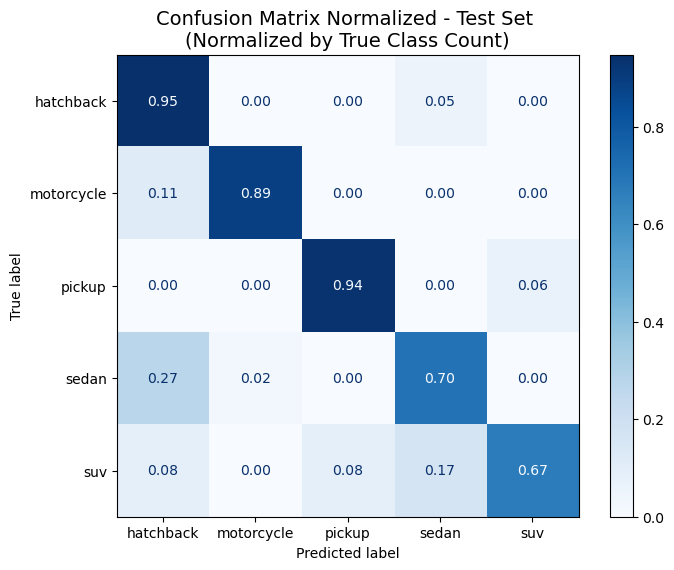

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

print(len(all_preds_test))
print(len(all_true_test))

cm = confusion_matrix(all_true_test, all_preds_test, normalize='true')

class_names = ['hatchback', 'motorcycle', 'pickup', 'sedan', 'suv']

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))

disp.plot(ax=ax, cmap="Blues", values_format=".2f")

# Mindre fontstørrelse for class labels (aksene)
ax.tick_params(axis='both', labelsize=10)


plt.title("Confusion Matrix Normalized - Test Set \n(Normalized by True Class Count)", fontsize=14)
plt.show()


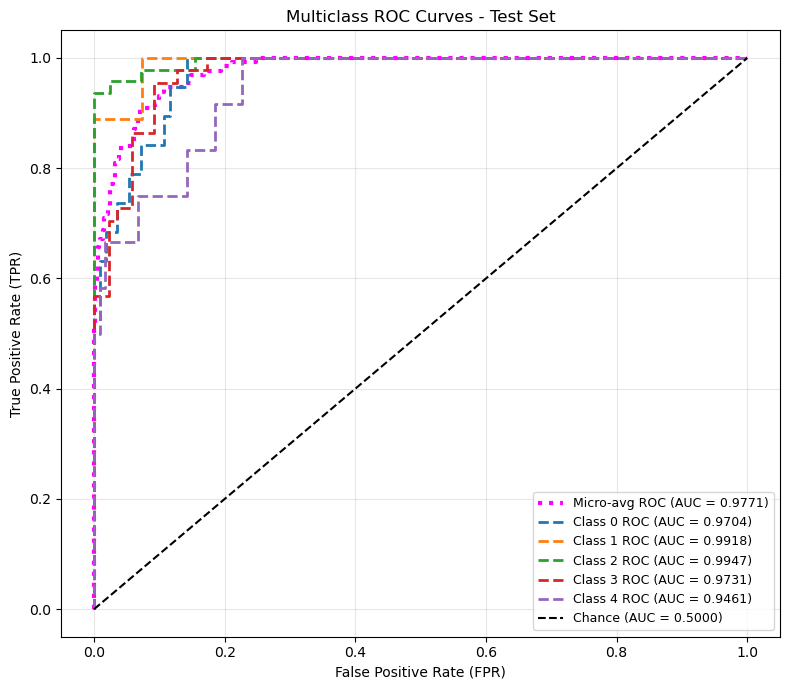

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# ==== 1. Kjør modellen og hent sannsynligheter ====

model.eval()

all_true = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_true.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

y_true = np.concatenate(all_true, axis=0)
y_score = np.concatenate(all_probs, axis=0)

num_classes = y_score.shape[1]

# Disse skal matche figuren din
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"]

# ==== 2. One-vs-rest binarisering ====

y_onehot_test = label_binarize(y_true, classes=np.arange(num_classes))

# ==== 3. Beregn ROC ====

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_onehot_test.ravel(), y_score.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ==== 4. Plot ====

fig, ax = plt.subplots(figsize=(8, 7))

# --- Micro-average curve (magenta dotted) ---
ax.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"Micro-avg ROC (AUC = {roc_auc['micro']:.4f})",
    color="magenta",
    linestyle=":",
    linewidth=3,
)

# --- Class curves (colors + dashed lines) ---
colors = [
    "tab:blue",      # Class 0
    "tab:orange",    # Class 1
    "tab:green",     # Class 2
    "tab:red",       # Class 3
    "tab:purple",    # Class 4
]

for i, color in zip(range(num_classes), colors):
    ax.plot(
        fpr[i],
        tpr[i],
        linestyle="--",
        linewidth=2,
        color=color,
        label=f"Class {i} ROC (AUC = {roc_auc[i]:.4f})",
    )

# --- Chance line ---
ax.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.5000)")

# Layout
ax.set_title("Multiclass ROC Curves - Test Set")
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.legend(loc="lower right", fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [32]:
model2 = FINAL_CNN(num_classes=5)
model.to(device)

optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


import time
import torch
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# === SETUP ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

num_epochs = 35
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model2.to(device)

epoch_times = []
train_losses = []
train_accuracies = []

print("Starting training...")

# === TRAINING LOOP (MEASURE EVERYTHING) ===
total_training_start = time.time()

for epoch in range(num_epochs):
    model2.train()
    correct = 0
    total = 0
    train_loss_epoch = 0

    start_epoch_time = time.time()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    end_epoch_time = time.time()

    # store stats
    epoch_times.append(end_epoch_time - start_epoch_time)
    train_losses.append(train_loss_epoch / total)
    train_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_losses[-1]:.4f} - Acc: {train_accuracies[-1]:.2f}%")

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
avg_epoch_time = np.mean(epoch_times)

print("\nTraining finished.\n")

# === TEST METRICS ===
print("Evaluating on test set...")

model2.eval()
test_correct = 0
test_total = 0
test_loss_total = 0

all_probs = []
all_true = []
inference_times = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # inference timer
        start_inf = time.time()
        outputs = model2(images)
        end_inf = time.time()

        inference_times.append(end_inf - start_inf)

        # loss
        loss = criterion(outputs, labels)
        test_loss_total += loss.item() * images.size(0)

        # accuracy
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        # ROC-AUC inputs
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_true.append(labels.cpu().numpy())

# final stats
test_accuracy = 100 * test_correct / test_total
test_cross_entropy = test_loss_total / test_total

all_probs = np.vstack(all_probs)
all_true = np.concatenate(all_true)

# one-hot for ROC
num_classes = all_probs.shape[1]
y_true_onehot = np.eye(num_classes)[all_true]

roc_auc_micro = roc_auc_score(y_true_onehot, all_probs, average="micro")
avg_inference_time = np.mean(inference_times) / images.size(0)  # per sample

# === PRINT RESULTS ===
print("===== CNN PERFORMANCE METRICS =====")
print(f"Train Accuracy:            {train_accuracies[-1]:.2f} %")
print(f"Test Accuracy:             {test_accuracy:.2f} %")
print(f"ROC-AUC (micro):           {roc_auc_micro:.4f}")
print(f"Cross-entropy (Train):     {train_losses[-1]:.4f}")
print(f"Cross-entropy (Test):      {test_cross_entropy:.4f}")

print("\n===== TEMPORAL METRICS =====")
print(f"Average Epoch Time:        {avg_epoch_time:.3f} seconds")
print(f"Total Training Time:       {total_training_time:.3f} seconds")
print(f"Avg Inference Time/sample: {avg_inference_time*1000:.4f} ms")

print("\nDone.")


Starting training...
Epoch 1/35 - Loss: 1.3916 - Acc: 42.46%
Epoch 2/35 - Loss: 1.1837 - Acc: 56.39%
Epoch 3/35 - Loss: 1.1497 - Acc: 55.53%
Epoch 4/35 - Loss: 1.0016 - Acc: 62.21%
Epoch 5/35 - Loss: 0.9326 - Acc: 65.84%
Epoch 6/35 - Loss: 0.9575 - Acc: 64.22%
Epoch 7/35 - Loss: 0.9159 - Acc: 65.84%
Epoch 8/35 - Loss: 0.8287 - Acc: 68.99%
Epoch 9/35 - Loss: 0.7691 - Acc: 71.37%
Epoch 10/35 - Loss: 0.7560 - Acc: 71.85%
Epoch 11/35 - Loss: 0.7472 - Acc: 71.95%
Epoch 12/35 - Loss: 0.7569 - Acc: 72.04%
Epoch 13/35 - Loss: 0.7241 - Acc: 73.57%
Epoch 14/35 - Loss: 0.6747 - Acc: 74.90%
Epoch 15/35 - Loss: 0.6943 - Acc: 73.85%
Epoch 16/35 - Loss: 0.6606 - Acc: 75.57%
Epoch 17/35 - Loss: 0.6401 - Acc: 75.76%
Epoch 18/35 - Loss: 0.6689 - Acc: 74.14%
Epoch 19/35 - Loss: 0.6382 - Acc: 76.43%
Epoch 20/35 - Loss: 0.6019 - Acc: 77.19%
Epoch 21/35 - Loss: 0.5598 - Acc: 79.29%
Epoch 22/35 - Loss: 0.5847 - Acc: 77.77%
Epoch 23/35 - Loss: 0.5405 - Acc: 78.82%
Epoch 24/35 - Loss: 0.6082 - Acc: 77.39%
Epoc